# CycleGAN for SVHN --> MNIST transfer
Adaptation of this [paper](https://arxiv.org/pdf/1703.10593.pdf) for transforming the SVHN domain to the MNIST one

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from torchvision import datasets
from torchvision import transforms

In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the datasets

In [3]:
def normalize(x, max_value):
    """ Normalize the input between -1 and 1 """
    return (x / float(max_value)) * 2 - 1

### SVHN

In [4]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
svhn = datasets.SVHN(root="/home/arthur/datasets/svhn", download=False, transform=transform)

In [6]:
X_svhn = svhn.data
X_svhn = normalize(X_svhn.reshape(len(X_svhn), 32, 32, 3), 256)
Y_svhn = svhn.labels.flatten()%10
X_svhn.shape

(73257, 32, 32, 3)

### MNIST

In [7]:
mnist = input_data.read_data_sets('/home/arthur/datasets/mnist', one_hot=False)

Extracting /home/arthur/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/arthur/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/arthur/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/arthur/datasets/mnist/t10k-labels-idx1-ubyte.gz


In [8]:
X_mnist = mnist.train.images
X_mnist = normalize(X_mnist.reshape(len(X_mnist), 28, 28, 1), 1)
Y_mnist = mnist.train.labels
X_mnist.shape

(55000, 28, 28, 1)

In [9]:
X_source = X_svhn
X_target = X_mnist

## Create the model

### Useful functions

In [10]:
def leaky_relu(x):
    alpha = 0.2
    return tf.maximum(x, alpha * x)

In [11]:
def instance_normalization(x, name):
    with tf.variable_scope("instance_norm"):
        with tf.variable_scope(name):
            epsilon = 1e-5
            mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
            scale = tf.get_variable('scale',[x.get_shape()[-1]], 
                initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.02))
            offset = tf.get_variable('offset',[x.get_shape()[-1]],initializer=tf.constant_initializer(0.0))
            out = scale*tf.div(x-mean, tf.sqrt(var+epsilon)) + offset

            return out

### Placeholders

In [12]:
ipt_source = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name='ipt_source')
ipt_target = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='ipt_target')

### Discriminator Network

In [13]:
def discriminator_s2t(x): 
    """ Take target as input and tell if it's generated or not """
    
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("discriminator", reuse=None):
        # Layer 1: Input 28x28x1. Output: 12x12x6
        conv1 = tf.layers.conv2d(x, 6, [5,5], strides=2, kernel_initializer=initializer, activation=leaky_relu)
        conv1 = instance_normalization(conv1, "conv1")
        
        # Layer 2: Input 12x12x6. Output: 4x4x16        
        conv2 = tf.layers.conv2d(conv1, 16, [5,5], strides=2, kernel_initializer=initializer, activation=leaky_relu)
        conv2 = instance_normalization(conv2, "conv2")

        # Layer 3: Input: 4x4x16 (=256). Output: 120
        fc1 = tf.contrib.layers.flatten(conv2)
        fc1 = tf.layers.dense(inputs=fc1, units=120, activation=leaky_relu, kernel_initializer=initializer)
    
        # Layer 4: Input 120. Output 84
        fc2 = tf.layers.dense(inputs=fc1, units=84, activation=leaky_relu, kernel_initializer=initializer)
        
        # Layer 5: Input 84. Output 1
        fc3 = tf.layers.dense(inputs=fc2, units=1, activation=None, kernel_initializer=initializer)
    
    return fc3

In [14]:
def discriminator_t2s(x): 
    """ Take source as input and tell if it's generated or not """
    
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("discriminator"):
        # Layer 1: Input 32x32x3. Output: 14x14x6
        conv1 = tf.layers.conv2d(x, 6, [5,5], strides=2, kernel_initializer=initializer, activation=leaky_relu)
        conv1 = instance_normalization(conv1, "conv1")
        
        # Layer 2: Input 14x14x6. Output: 5x5x16        
        conv2 = tf.layers.conv2d(conv1, 16, [5,5], strides=2, kernel_initializer=initializer, activation=leaky_relu)
        conv2 = instance_normalization(conv2, "conv2")

        # Layer 3: Input: 5x5x16 (=400). Output: 120
        fc1 = tf.contrib.layers.flatten(conv2)
        fc1 = tf.layers.dense(inputs=fc1, units=120, activation=leaky_relu, kernel_initializer=initializer)
    
        # Layer 4: Input 120. Output 84
        fc2 = tf.layers.dense(inputs=fc1, units=84, activation=leaky_relu, kernel_initializer=initializer)
        
        # Layer 5: Input 84. Output 1
        fc3 = tf.layers.dense(inputs=fc2, units=1, activation=None, kernel_initializer=initializer)
    
    return fc3

### Generator Network

In [15]:
def generator_s2t(x):
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("generator", reuse=None):
        # Layer 1: Input 32x32x3. Output 14x14x6
        conv1 = tf.layers.conv2d(x, 6, [5,5], strides=2, kernel_initializer=initializer, activation=tf.nn.relu)
        conv1 = instance_normalization(conv1, "conv1")
        
        # Layer 2: Input 14x14x6. Output 5x5x16        
        conv2 = tf.layers.conv2d(conv1, 16, [5,5], strides=2, kernel_initializer=initializer, activation=tf.nn.relu)
        conv2 = instance_normalization(conv2, "conv2")
        
        # Layer 3: Input 5x5x16. Output 13x13x6 (2*n-1 + size-1)
        deconv1 = tf.layers.conv2d_transpose(conv2, 6, [5,5], strides=2, kernel_initializer=initializer, activation=tf.nn.relu)
        deconv1 = instance_normalization(deconv1, "deconv1")
        
        # Layer 4: Input 13x13x6. Output: 28x28x1
        deconv2 = tf.layers.conv2d_transpose(deconv1, 1, [4,4], strides=2, kernel_initializer=initializer, activation=tf.nn.tanh)
    
    return deconv2

In [16]:
def generator_t2s(x):
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("generator", reuse=None):
        # Layer 1: Input 28x28x1. Output: 12x12x6
        conv1 = tf.layers.conv2d(x, 10, [5,5], strides=2, kernel_initializer=initializer, activation=tf.nn.relu)
        conv1 = instance_normalization(conv1, "conv1")
        
        # Layer 2: Input 12x12x6. Output: 4x4x16        
        conv2 = tf.layers.conv2d(conv1, 30, [5,5], strides=2, kernel_initializer=initializer, activation=tf.nn.relu)
        conv2 = instance_normalization(conv2, "conv2")

        # Layer 3: Input 4x4x16. Output 13x13x6 (2*n-1 + size-1)
        deconv1 = tf.layers.conv2d_transpose(conv2, 10, [7,7], strides=2, kernel_initializer=initializer, activation=tf.nn.relu)
        deconv1 = instance_normalization(deconv1, "deconv1")
        
        # Layer 4: Input 13x13x6. Output: 28x28x1
        deconv2 = tf.layers.conv2d_transpose(deconv1, 3, [8,8], strides=2, kernel_initializer=initializer, activation=tf.nn.tanh)
    
    return deconv2

### Losses and solver

#### Useful functions

In [17]:
def log(tensor):
    return tf.log(tf.maximum(tensor, 1e-9))

#### Define the graph

In [18]:
with tf.variable_scope("s2t") as scope:
    D_target = discriminator_s2t(ipt_target)
    G_source = generator_s2t(ipt_source)
    scope.reuse_variables()
    DG_source = discriminator_s2t(G_source)

In [19]:
G_source.get_shape()

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

In [20]:
with tf.variable_scope("t2s") as scope:
    D_source = discriminator_t2s(ipt_source)
    G_target = generator_t2s(ipt_target)
    scope.reuse_variables()
    DG_target = discriminator_t2s(G_target)

In [21]:
G_target.get_shape()

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(3)])

In [22]:
with tf.variable_scope("s2t", reuse=True) as scope:
    cyc_target = generator_s2t(G_target)

In [23]:
with tf.variable_scope("t2s", reuse=True) as scope:
    cyc_source = generator_t2s(G_source)

#### Losses

In [24]:
lambda_cyc = 1

In [25]:
cyc_loss = tf.losses.mean_squared_error(ipt_source, cyc_source) + tf.losses.mean_squared_error(ipt_target, cyc_target)
tf.summary.scalar("cyc_loss", cyc_loss)

<tf.Tensor 'cyc_loss:0' shape=() dtype=string>

In [26]:
D_s2t_loss = tf.reduce_mean(DG_source) - tf.reduce_mean(D_target)
G_s2t_loss = -tf.reduce_mean(DG_source) + lambda_cyc*cyc_loss

tf.summary.scalar("D_s2t_loss", D_s2t_loss)
tf.summary.scalar("G_s2t_loss", G_s2t_loss)

<tf.Tensor 'G_s2t_loss:0' shape=() dtype=string>

In [27]:
D_t2s_loss = tf.reduce_mean(DG_target) - tf.reduce_mean(D_source)
G_t2s_loss = -tf.reduce_mean(DG_target) + lambda_cyc*cyc_loss
tf.summary.scalar("D_t2s_loss", D_t2s_loss)
tf.summary.scalar("G_t2s_loss", D_t2s_loss)

<tf.Tensor 'G_t2s_loss:0' shape=() dtype=string>

#### Solvers

In [28]:
model_vars = tf.trainable_variables()

D_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='s2t/discriminator')
G_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='s2t/generator')
D_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='t2s/discriminator')
G_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='t2s/generator')

In [29]:
D_s2t_solver = tf.train.RMSPropOptimizer(learning_rate=1e-2).minimize(D_s2t_loss, var_list=D_s2t_vars)
G_s2t_solver = tf.train.RMSPropOptimizer(learning_rate=1e-2).minimize(G_s2t_loss, var_list=G_s2t_vars)
D_t2s_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(D_t2s_loss, var_list=D_t2s_vars)
G_t2s_solver = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(G_t2s_loss, var_list=G_t2s_vars)

In [30]:
clip_D_s2t = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in D_s2t_vars]
clip_D_t2s = [p.assign(tf.clip_by_value(p, -0.1, 0.1)) for p in D_t2s_vars]

## Run the model

In [31]:
sess = tf.InteractiveSession()

In [32]:
import shutil
shutil.rmtree('log/')

In [33]:
summary_writer = tf.summary.FileWriter('log/', sess.graph)

In [34]:
merged_summary = tf.summary.merge_all()

In [35]:
sess.run(tf.global_variables_initializer())
D_s2t_loss_list = []
G_s2t_loss_list = []
D_t2s_loss_list = []
G_t2s_loss_list = []
cyc_loss_list = []
iter_list = []
i = 0

In [48]:
nb_iter = 300
nb_iter_d = 20
nb_iter_g = 1
nb_samples = 40
G_s2t_loss_curr = 0.001
D_s2t_loss_curr = 0.001
G_t2s_loss_curr = 0.001
D_t2s_loss_curr = 0.001
cyc_loss_curr = 0.001

for i in range(i, nb_iter+i):
    for k in range(nb_iter_g):
        sample_source = X_source[np.random.choice(len(X_source), nb_samples)]
        sample_target = X_target[np.random.choice(len(X_target), nb_samples)]
        
        # Optimizing s2t
        _, G_s2t_loss_curr = sess.run([G_s2t_solver, G_s2t_loss], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    
        ## Optimizing t2s
        _, G_t2s_loss_curr = sess.run([G_t2s_solver, G_t2s_loss], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
        
    for k in range(nb_iter_d):
        sample_source = X_source[np.random.choice(len(X_source), nb_samples)]
        sample_target = X_target[np.random.choice(len(X_target), nb_samples)]
        
        # Optimizing s2t
        _, D_s2t_loss_curr,_ = sess.run([D_s2t_solver, D_s2t_loss, clip_D_s2t], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    
        ## Optimizing t2s
        _, D_t2s_loss_curr,_ = sess.run([D_t2s_solver, D_t2s_loss, clip_D_t2s], feed_dict={ipt_source: sample_source, ipt_target: sample_target})

    iter_list.append(i)
    D_s2t_loss_list.append(D_s2t_loss_curr)
    G_s2t_loss_list.append(G_s2t_loss_curr)
    D_t2s_loss_list.append(D_t2s_loss_curr)
    G_t2s_loss_list.append(G_t2s_loss_curr)
    cyc_loss_list.append(cyc_loss_curr)
        
    if i % (nb_iter//5) == 0:
        cyc_loss_curr, summary = sess.run([cyc_loss, merged_summary], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
        
        summary_writer.add_summary(summary, i)
        
        print('Iter: {}'.format(i))
        print('D loss s2t: {:.4}'.format(D_s2t_loss_curr))
        print('D loss t2s: {:.4}'.format(D_t2s_loss_curr))
        print('G loss s2t: {:.4}'.format(G_s2t_loss_curr))
        print('G loss t2s: {:.4}'.format(G_t2s_loss_curr))
        print('Cycle-loss: {:.4}'.format(cyc_loss_curr))
        print()
        
summary_writer.flush()

Iter: 240
D loss s2t: -32.54
D loss t2s: -163.4
G loss s2t: -16.24
G loss t2s: 115.9
Cycle-loss: 0.8763

Iter: 300
D loss s2t: -34.68
D loss t2s: -159.7
G loss s2t: 18.12
G loss t2s: 119.0
Cycle-loss: 0.9157

Iter: 360
D loss s2t: -35.8
D loss t2s: -186.4
G loss s2t: 64.57
G loss t2s: 116.7
Cycle-loss: 0.8671

Iter: 420
D loss s2t: -11.76
D loss t2s: -178.9
G loss s2t: 62.32
G loss t2s: 116.9
Cycle-loss: 0.9235

Iter: 480
D loss s2t: -31.49
D loss t2s: -180.6
G loss s2t: 57.23
G loss t2s: 121.6
Cycle-loss: 0.901



## Display the results

In [49]:
def unnormalize(x):
    return (x + 1)/2

In [50]:
X_source_trans = unnormalize(sess.run(G_source, feed_dict={ipt_source: X_source[:50]}))
X_target_trans = unnormalize(sess.run(G_target, feed_dict={ipt_target: X_target[:50]}))
X_source_cyc = unnormalize(sess.run(cyc_source, feed_dict={ipt_source: X_source[:50]}))
X_target_cyc = unnormalize(sess.run(cyc_target, feed_dict={ipt_target: X_target[:50]}))

(-0.5, 27.5, 27.5, -0.5)

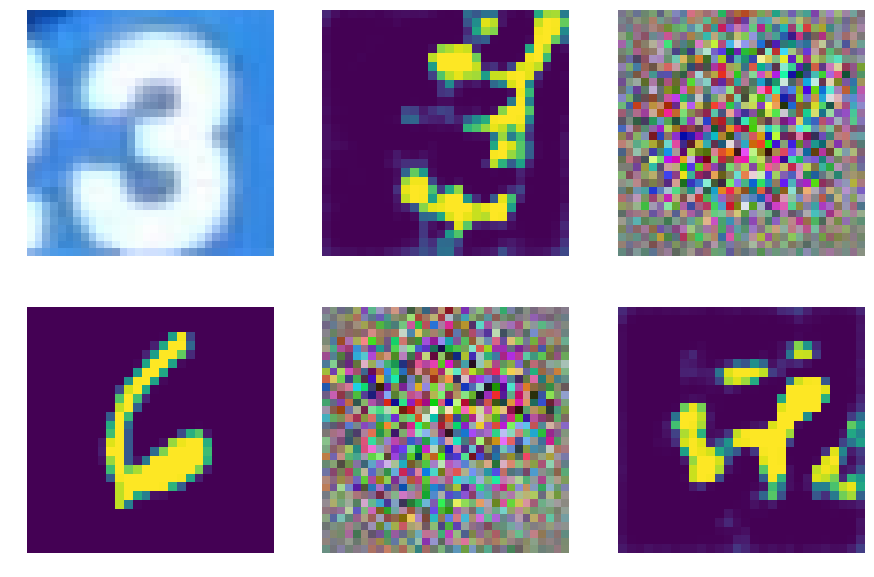

In [51]:
plt.rcParams['figure.figsize'] = (15, 10)
# plt.axes().set_aspect('equal', 'datalim')
#plt.axis([-3,3,-3,3])

index = 3
plt.subplot(2,3,1)
plt.imshow(unnormalize(np.transpose(X_svhn[index].reshape(3,32,32), (1,2,0))))
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(X_source_trans[index].reshape(28,28))
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(X_source_cyc[index].reshape(32,32,3))
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(unnormalize(X_target[index].reshape(28,28)))
plt.axis('off')

plt.subplot(2,3,5)
#plt.imshow(np.transpose(X_target_trans[index].reshape(3,32,32), (1,2,0)))
plt.imshow(X_target_trans[index].reshape(32,32,3))
plt.axis('off')

plt.subplot(2,3,6)
#plt.imshow(np.transpose(X_target_trans[index].reshape(3,32,32), (1,2,0)))
plt.imshow(X_target_cyc[index].reshape(28,28))
plt.axis('off')


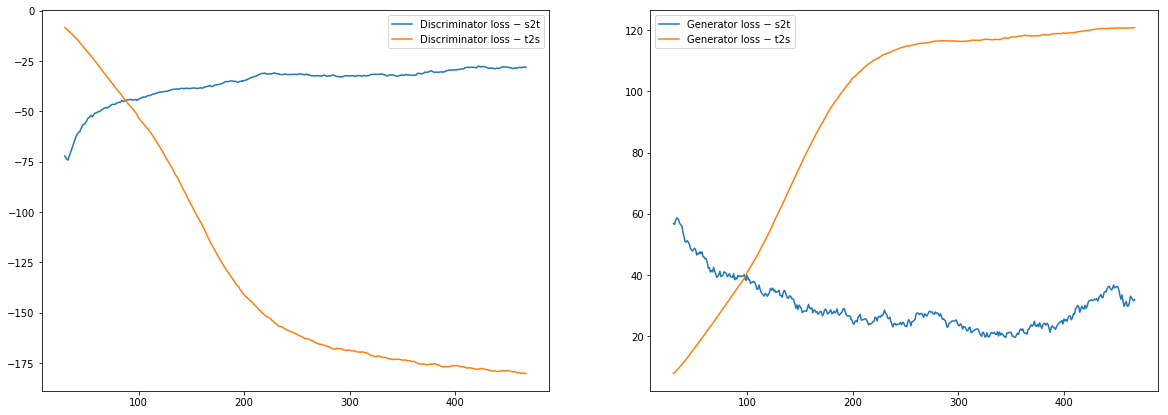

In [54]:
k = 30
def smooth(x_list):
    return np.array([1/(2*k) * np.sum([x_list[i+j] for j in range(-k, k)]) for i in range(k, len(x_list)-k)])

plt.rcParams['figure.figsize'] = (20, 7)

plt.subplot(1,2,1)
plt.plot(iter_list[k:-k], smooth(D_s2t_loss_list), label="Discriminator loss − s2t")
plt.plot(iter_list[k:-k], smooth(D_t2s_loss_list), label="Discriminator loss − t2s")
plt.legend()

plt.subplot(1,2,2)
plt.plot(iter_list[k:-k], smooth(G_s2t_loss_list), label="Generator loss − s2t")
plt.plot(iter_list[k:-k], smooth(G_t2s_loss_list), label="Generator loss − t2s")
plt.legend()

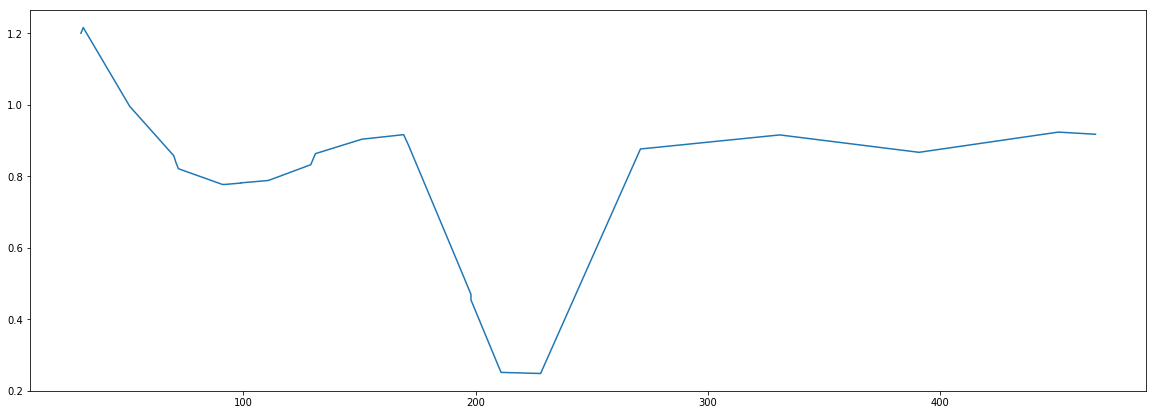

In [55]:
plt.plot(iter_list[k:-k], smooth(cyc_loss_list), label="Cycle loss")

## Debug

In [56]:
#X_target_trans[10][:,:,:]

### Gradients

In [57]:
ind = 1
print("Gradient with respect to", D_s2t_vars[ind])
gradient = sess.run(tf.gradients(D_s2t_loss, D_s2t_vars[ind]), feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

Gradient with respect to <tf.Variable 's2t/discriminator/conv2d/bias:0' shape=(6,) dtype=float32_ref>
Min: -10.5886
Max: 4.29991
Avg: -2.03625


In [58]:
ind = 1
print("Gradient with respect to", G_s2t_vars[ind])
gradient = sess.run(tf.gradients(G_s2t_loss, G_s2t_vars[ind]), feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

Gradient with respect to <tf.Variable 's2t/generator/conv2d/bias:0' shape=(6,) dtype=float32_ref>
Min: -8.65157
Max: 2.60078
Avg: -0.623495


In [59]:
ind = 10
print("Gradient with respect to", D_t2s_vars[ind])
gradient = sess.run(tf.gradients(D_t2s_loss, D_t2s_vars[ind]), feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

Gradient with respect to <tf.Variable 't2s/discriminator/dense_1/kernel:0' shape=(120, 84) dtype=float32_ref>
Min: -0.338754
Max: 0.0672802
Avg: -0.136133


In [60]:
ind = 10
print("Gradient with respect to", G_t2s_vars[ind])
gradient = sess.run(tf.gradients(G_t2s_loss, G_t2s_vars[ind]), feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print("Min:", np.array(gradient).min())
print("Max:", np.array(gradient).max())
print("Avg:", np.array(gradient).mean())

Gradient with respect to <tf.Variable 't2s/generator/instance_norm/deconv1/scale:0' shape=(10,) dtype=float32_ref>
Min: -4.68704
Max: 1.37902
Avg: -1.17649


In [61]:
D_s2t_vars[ind]

<tf.Variable 's2t/discriminator/dense_1/kernel:0' shape=(120, 84) dtype=float32_ref>

In [77]:
D_s2t_vars

[<tf.Variable 's2t/discriminator/conv2d/kernel:0' shape=(5, 5, 1, 6) dtype=float32_ref>,
 <tf.Variable 's2t/discriminator/conv2d/bias:0' shape=(6,) dtype=float32_ref>,
 <tf.Variable 's2t/discriminator/conv2d_1/kernel:0' shape=(5, 5, 6, 16) dtype=float32_ref>,
 <tf.Variable 's2t/discriminator/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 's2t/discriminator/dense/kernel:0' shape=(216, 120) dtype=float32_ref>,
 <tf.Variable 's2t/discriminator/dense/bias:0' shape=(120,) dtype=float32_ref>,
 <tf.Variable 's2t/discriminator/dense_1/kernel:0' shape=(120, 84) dtype=float32_ref>,
 <tf.Variable 's2t/discriminator/dense_1/bias:0' shape=(84,) dtype=float32_ref>,
 <tf.Variable 's2t/discriminator/dense_2/kernel:0' shape=(84, 1) dtype=float32_ref>,
 <tf.Variable 's2t/discriminator/dense_2/bias:0' shape=(1,) dtype=float32_ref>]